In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Reshape
from tensorflow import keras
from pvlib import location

# Przygotowanie danych:

In [2]:
df = read_csv('data/data_single_loc.csv')
df.head()

,t2m,d2m,msl,tp,ssrd,Date Time,windspeed_10,windspeed_100
0,262.714033,259.900872,103298.015394,0.0,0.0,1950-01-01 00:00:00,2.489513,3.817744
1,260.695745,258.184905,103401.866726,0.0,0.0,1950-01-01 01:00:00,1.837656,3.726080
2,260.195929,257.699157,103434.928307,0.0,0.0,1950-01-01 02:00:00,2.599009,3.537574
3,259.350219,256.948053,103418.318422,0.0,0.0,1950-01-01 03:00:00,2.534284,3.147813
4,258.763065,256.665744,103419.030274,0.0,0.0,1950-01-01 04:00:00,2.623488,3.713367


## Wybór zestawu uczacego i testowego:

Train - 8 lat (1994-2002)
Test - 1 rok (2003)

In [3]:
train = df[df['Date Time']>='1994-01-01']
train = train[train['Date Time']<'2002-01-01']

test = df[df['Date Time']>='2002-01-01']
test = test[test['Date Time']<'2003-01-01']

## Zamiana daty na sygnał

In [23]:
def datetimeToSignal(df):
    date_time = pd.to_datetime(df.pop('Date Time'), infer_datetime_format=True)

    def datetime_to_seconds(dates):
        return (float)((dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))

    timestamp_s = date_time.map(datetime_to_seconds)

    day = 24*60*60
    year = (365.2425)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    return df

Text(0.5, 1.0, 'Time of day signal')

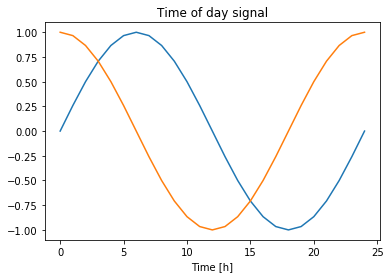

In [5]:
train = datetimeToSignal(train)
test = datetimeToSignal(test)

plt.plot(np.array(train['Day sin'])[:25])
plt.plot(np.array(train['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [6]:
train

,t2m,d2m,msl,tp,ssrd,windspeed_10,windspeed_100,Day sin,Day cos,Year sin,Year cos
385704,276.591343,273.596620,100506.632367,1.932132e-06,0.0,2.114060,5.361759,-1.194924e-12,1.000000,0.003096,0.999995
385705,276.239701,273.369400,100396.343001,4.458765e-07,0.0,2.405930,5.321845,2.588190e-01,0.965926,0.003813,0.999993
385706,276.160200,273.007005,100208.231961,-4.336809e-19,0.0,2.965422,6.456552,5.000000e-01,0.866025,0.004530,0.999990
385707,276.464446,273.140248,100168.421244,-4.336809e-19,0.0,2.014878,4.494060,7.071068e-01,0.707107,0.005247,0.999986
385708,276.756462,273.067511,100306.858875,1.426805e-05,0.0,2.988442,6.387299,8.660254e-01,0.500000,0.005964,0.999982
...,...,...,...,...,...,...,...,...,...,...,...
455827,268.716680,266.967547,102182.755406,3.642718e-04,0.0,4.235441,7.019842,-9.659258e-01,0.258819,0.000545,1.000000
455828,268.546564,266.426877,102303.220947,2.379452e-04,0.0,4.918338,7.976831,-8.660254e-01,0.500000,0.001262,0.999999
455829,268.176845,266.142083,102400.963686,2.041077e-04,0.0,5.307397,8.410755,-7.071068e-01,0.707107,0.001978,0.999998
455830,267.034420,264.758975,102492.461991,1.640441e-04,0.0,5.672091,9.402890,-5.000000e-01,0.866025,0.002695,0.999996


## Normalizacja

In [7]:
values_train = train.values
values_test = test.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values_train)
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_y.fit(values_train[:,4].reshape(len(values_train),1))

values_train = scaler.transform(values_train)
values_test = scaler.transform(values_test)

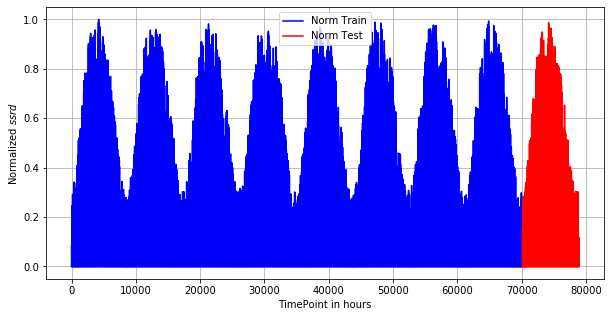

In [8]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in hours')
plt.ylabel('Normalized $ssrd$')
plt.grid()
plt.plot(range(len(values_train)),values_train[:,4],'b')
plt.plot(range(len(values_train),len(values_train)+len(values_test)),values_test[:,4],'r')
plt.legend(['Norm Train','Norm Test']);

## Zmiana szeregu czasowego na input/output

In [9]:
# Multiple steps predicted:

# # convert history into inputs and outputs
# def to_supervised(data, n_input, n_out=1):
#     X, y = list(), list()
#     in_start = 0
#     # step over the entire history one time step at a time
#     for _ in range(len(data)):
#         # define the end of the input sequence
#         in_end = in_start + n_input
#         out_end = in_end + n_out
#         # ensure we have enough data for this instance
#         if out_end < len(data):
#             X.append(data[in_start:in_end, :])
#             y.append(data[in_end:out_end, 0])
#         # move along one time step
#         in_start += 1
#     return array(X), array(y)

# One step predicted:
def to_supervised(data, n_input, n_out=1):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[out_end-1, 4]) # 4 indicates 'ssrd' parameter
        # move along one time step
        in_start += 1
    return array(X), array(y).reshape((len(y),1))

X_train, y_train = to_supervised(values_train, n_input=24, n_out=6)
X_test, y_test = to_supervised(values_test, n_input=24, n_out=6)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(70098, 24, 11)
(70098, 1)
(8730, 24, 11)
(8730, 1)


# Stworzenie i trening modeli

In [11]:
def compile_and_fit(model, X_train, y_train):
    early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                                                   patience=2,
                                                   mode='min')

    model.compile(loss='mean_squared_error',
                  optimizer='adam')

    model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[early_stopping])

def evaluate(model, X_test, y_test, display = True):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)

    # calculate RMSE
    testScore = sqrt(mean_squared_error(testYTrue, testPredictions))
    
    if display:
        print('Test Score: %.4f RMSE' % (testScore))
        length = 168
        start = random.randrange(len(testYTrue)-length)
        end = start+length
        plt.figure(figsize=[10,5])
        plt.xlabel('TimePoint in hours')
        plt.ylabel('$Surface solar radiation downwards [kW/m^{2}]$')
        plt.grid()
        plt.plot(range(length), testYTrue[start:end],'k.')
        plt.plot(range(length),testPredictions[start:end],'r')
        plt.legend(['Actual','Predicted'])

    return testScore

def cross_corr(model, X_test, y_test):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)
    testPredictions = testPredictions.reshape((testPredictions.shape[0]))
    testYTrue = testYTrue.reshape((testYTrue.shape[0]))

    plt.figure(figsize=[10,5])
    plt.xcorr(testYTrue, testPredictions, usevlines=False)
    plt.grid()
    plt.title("Cross correlation between predictions and actual values")


## Dense:

In [25]:
dense = Sequential([
    Dense(units=24, activation='relu', input_shape=(24,11)),
    Dense(units=24, activation='relu'),
    Dense(units=24, activation='relu'),
    Dense(1),
    Reshape([1,24]),
    Dense(1),
    Reshape([1])
])
dense.summary()
compile_and_fit(dense, X_train, y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24, 24)            288       
_________________________________________________________________
dense_1 (Dense)              (None, 24, 24)            600       
_________________________________________________________________
dense_2 (Dense)              (None, 24, 24)            600       
_________________________________________________________________
dense_3 (Dense)              (None, 24, 1)             25        
_________________________________________________________________
reshape (Reshape)            (None, 1, 24)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1, 1)              25        
_________________________________________________________________
reshape_1 (Reshape)          (None, 1)                 0

In [12]:
dense = keras.models.load_model('workdir/saved_models/ssrd_dense.h5')

Test Score: 0.0626 RMSE


0.06257216161206802

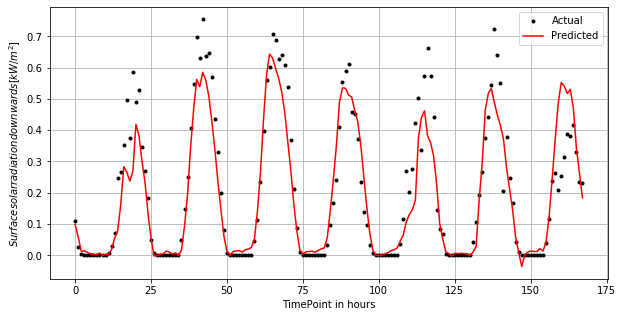

In [13]:
evaluate(dense, X_test, y_test)

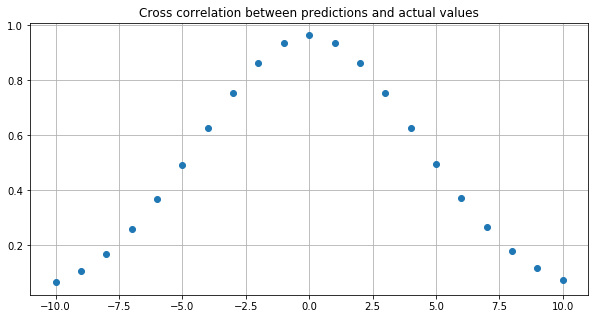

In [14]:
cross_corr(dense, X_test, y_test)

## LSTM

In [28]:
lstm = Sequential([
    LSTM(24, activation='relu', input_shape=(24,11), return_sequences=True),
    LSTM(24, activation='relu', return_sequences=True),
    LSTM(24, activation='relu'),
    Dense(1)
])
lstm.summary()
compile_and_fit(lstm, X_train, y_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 24)            3456      
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 24)            4704      
_________________________________________________________________
lstm_2 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 12,889
Trainable params: 12,889
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2191/2191 [==============================] - 702s 319ms/step - loss: 0.0084
Epoch 2/20
2191/2191 [==============================] - 717s 327ms/step - loss: 0.0067
Epoch 3/20
2191/2191 [==============================] - 681s 311ms/step - 

In [15]:
lstm = keras.models.load_model('workdir/saved_models/ssrd_lstm.h5')

Test Score: 0.0607 RMSE


0.060683594826207006

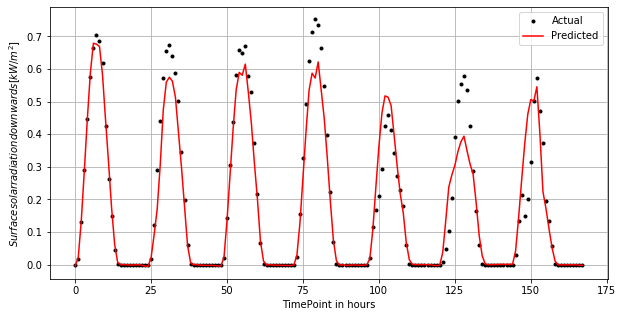

In [16]:
evaluate(lstm, X_test, y_test)

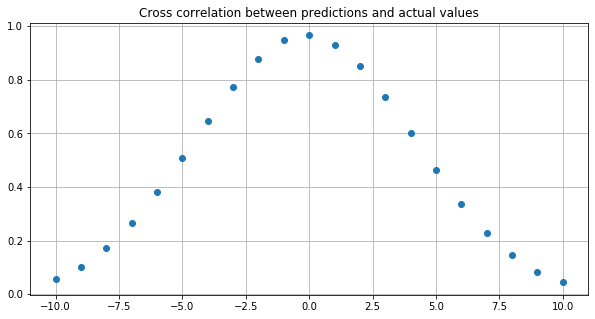

In [17]:
cross_corr(lstm, X_test, y_test)

# Porównanie wyników

In [18]:
years = range(2002,2020)
years = [str(x) for x in years]

Xs = []
ys = []
look_back = 24
forward = 6

for year in years:
    test = df[df['Date Time']>=(year+'-01-01')]
    test = test[test['Date Time']<(str(int(year)+1)+'-01-01')]
    test = datetimeToSignal(test)
    test = test.values
    test = scaler.transform(test)
    X, y = to_supervised(test, look_back, forward)
    Xs.append(X)
    ys.append(y)

In [19]:
class mean_baseline():
    def predict(X):
        X = X[:,:,4].reshape((X.shape[0], X.shape[1], 1))
        Y = []
        for item in X:
            Y.append(np.mean(item))
        Y = np.array(Y).reshape(len(Y),1)
        return Y

class last_baseline():
    def predict(X):
        X = X[:,:,4].reshape((X.shape[0], X.shape[1], 1))
        Y = []
        for item in X:
            Y.append(item[-1])
        Y = np.array(Y).reshape(len(Y),1)
        return Y

mean = mean_baseline
last = last_baseline

Text(0.5, 0, 'RMSE for years 2002-2020')

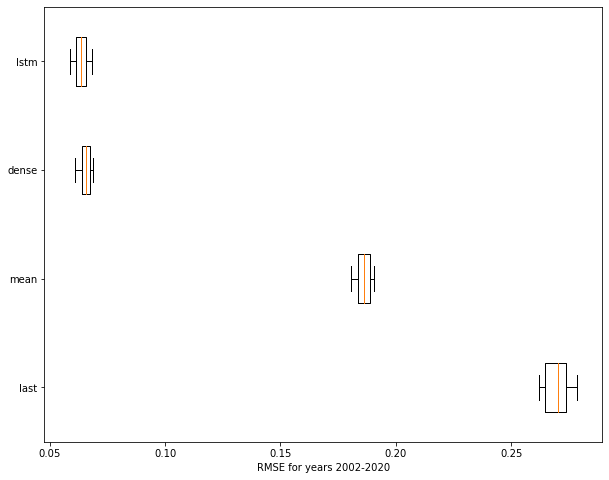

In [20]:
models = {
    "last": last,
    "mean": mean,
    "dense":dense, 
    "lstm":lstm
}

scores = {}
for key, model in models.items():
    rmses = []
    for i in range(len(years)):
        rmse = evaluate(model, Xs[i], ys[i], display=False)
        rmses.append(rmse)
    scores[key] = rmses

plt.figure(figsize=(10,8))
plt.boxplot(scores.values(), vert=False, labels=scores.keys())
plt.xlabel("RMSE for years 2002-2020")

# Concept drift

Text(0, 0.5, 'RMSE')

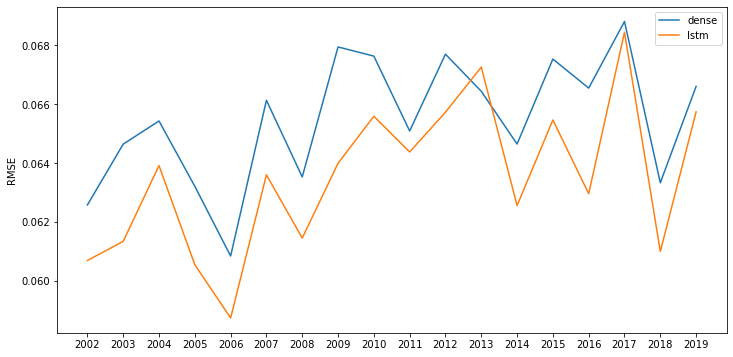

In [21]:
plt.figure(figsize=(12,6))
for key in ['dense','lstm']:
    plt.plot(years, scores[key])
plt.legend(['dense','lstm'])
plt.ylabel("RMSE")

# ssrd/clearsky

In [164]:
df = read_csv('data/data_single_loc.csv')
df.head()

,t2m,d2m,msl,tp,ssrd,Date Time,windspeed_10,windspeed_100
0,262.714033,259.900872,103298.015394,0.0,0.0,1950-01-01 00:00:00,2.489513,3.817744
1,260.695745,258.184905,103401.866726,0.0,0.0,1950-01-01 01:00:00,1.837656,3.726080
2,260.195929,257.699157,103434.928307,0.0,0.0,1950-01-01 02:00:00,2.599009,3.537574
3,259.350219,256.948053,103418.318422,0.0,0.0,1950-01-01 03:00:00,2.534284,3.147813
4,258.763065,256.665744,103419.030274,0.0,0.0,1950-01-01 04:00:00,2.623488,3.713367


In [165]:
tz = 'CET'
lat, lon = 50, 20
site = location.Location(lat, lon, tz=tz)
times = pd.DatetimeIndex(pd.to_datetime(df['Date Time']))

clearsky = site.get_clearsky(times)
clearsky = clearsky.reset_index().drop('Date Time', axis=1)
clearsky = clearsky/1000


In [166]:
df = df.join(clearsky)

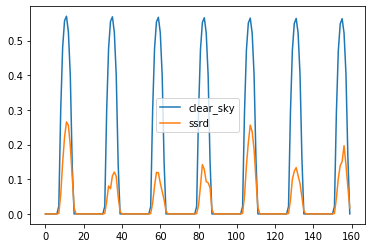

In [168]:
plt.plot(df['dni'][0:160])
plt.plot(df['ssrd'][0:160])
# plt.plot(df['dni'][0:160])
plt.legend(labels = ['clear_sky','ssrd'])

In [142]:
df = df[(df.dni != 0) & (df.ssrd != 0)]

In [143]:
df['dni-ssrd'] = df.pop('dni')-df.pop('ssrd')
# df['dni-ssrd'] = df.pop('ssrd')/df.pop('dni')
df.pop('ghi')
df.pop('dhi')

7         0.003199
8         0.034780
9         0.053917
10        0.062529
11        0.063999
            ...   
622378    0.062112
622379    0.063536
622380    0.058370
622381    0.044765
622382    0.017366
Name: dhi, Length: 313701, dtype: float64

In [144]:
df

,t2m,d2m,msl,tp,Date Time,windspeed_10,windspeed_100,dni-ssrd
7,260.214088,257.760336,103520.192386,1.433720e-06,1950-01-01 07:00:00,2.060462,3.662126,0.020681
8,258.568500,256.578029,103563.536278,9.558135e-07,1950-01-01 08:00:00,2.202180,3.918888,0.244536
9,261.731695,258.893258,103649.591303,9.558135e-07,1950-01-01 09:00:00,2.885008,4.254731,0.332441
10,265.285750,261.884406,103589.795716,9.558135e-07,1950-01-01 10:00:00,3.506345,4.858961,0.336059
11,265.440537,261.658854,103548.429191,4.779068e-07,1950-01-01 11:00:00,3.340235,4.540498,0.304931
...,...,...,...,...,...,...,...,...
622378,274.690947,274.472685,101064.036412,4.292173e-05,2020-12-31 10:00:00,0.917266,0.910681,0.480674
622379,274.962275,274.186172,101008.983615,2.573735e-05,2020-12-31 11:00:00,1.018674,0.995560,0.450259
622380,275.590991,274.257929,100940.747855,1.051465e-05,2020-12-31 12:00:00,1.331610,1.576817,0.424716
622381,275.765501,274.179977,100909.647203,2.824831e-06,2020-12-31 13:00:00,1.236320,1.534706,0.324458


In [145]:
train = df[df['Date Time']>='1994-01-01']
train = train[train['Date Time']<'2002-01-01']

test = df[df['Date Time']>='2002-01-01']
test = test[test['Date Time']<'2003-01-01']

In [146]:
train = datetimeToSignal(train)
test = datetimeToSignal(test)

In [147]:
values_train = train.values
values_test = test.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values_train)
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_y.fit(values_train[:,6].reshape(len(values_train),1))

values_train = scaler.transform(values_train)
values_test = scaler.transform(values_test)

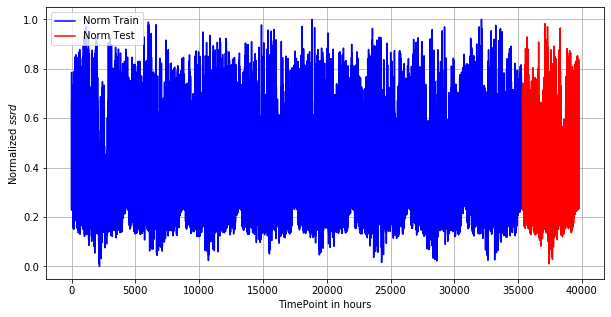

In [148]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in hours')
plt.ylabel('Normalized $ssrd$')
plt.grid()
plt.plot(range(len(values_train)),values_train[:,6],'b')
plt.plot(range(len(values_train),len(values_train)+len(values_test)),values_test[:,6],'r')
plt.legend(['Norm Train','Norm Test']);

In [149]:
# One step predicted:
def to_supervised(data, n_input, n_out=1):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[out_end-1, 6]) # 4 indicates 'ssrd' parameter
        # move along one time step
        in_start += 1
    return array(X), array(y).reshape((len(y),1))

X_train, y_train = to_supervised(values_train, n_input=24, n_out=6)
X_test, y_test = to_supervised(values_test, n_input=24, n_out=6)

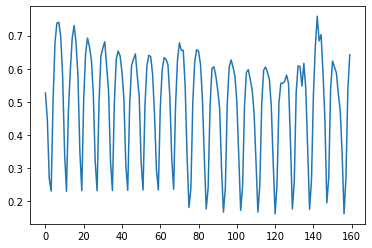

In [150]:
plt.plot(y_test[:160])

In [151]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(35309, 24, 11)
(35309, 1)
(4385, 24, 11)
(4385, 1)


In [171]:
def compile_and_fit(model, X_train, y_train):
    early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                                                   patience=2,
                                                   mode='min')

    model.compile(loss='mean_squared_error',
                  optimizer='adam')

    model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[early_stopping])

def evaluate(model, X_test, y_test, display = True):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)

    # calculate RMSE
    testScore = sqrt(mean_squared_error(testYTrue, testPredictions))
    
    if display:
        print('Test Score: %.4f RMSE' % (testScore))
        length = 168
        start = random.randrange(len(testYTrue)-length)
        end = start+length
        plt.figure(figsize=[10,5])
        plt.xlabel('TimePoint in hours')
        plt.ylabel('$Clearsky-SSRD [kW/m^2]$')
        plt.grid()
        plt.plot(range(length), testYTrue[start:end],'k.')
        plt.plot(range(length),testPredictions[start:end],'r')
        plt.legend(['Actual','Predicted'])

    return testScore

def cross_corr(model, X_test, y_test):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)
    testPredictions = testPredictions.reshape((testPredictions.shape[0]))
    testYTrue = testYTrue.reshape((testYTrue.shape[0]))

    plt.figure(figsize=[10,5])
    plt.xcorr(testYTrue, testPredictions, usevlines=False)
    plt.grid()
    plt.title("Cross correlation between predictions and actual values")

In [153]:
dense = Sequential([
    Dense(units=24, activation='relu', input_shape=(24,11)),
    Dense(units=24, activation='relu'),
    Dense(units=24, activation='relu'),
    Dense(1),
    Reshape([1,24]),
    Dense(1),
    Reshape([1])
])
dense.summary()
compile_and_fit(dense, X_train, y_train)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 24, 24)            288       
_________________________________________________________________
dense_21 (Dense)             (None, 24, 24)            600       
_________________________________________________________________
dense_22 (Dense)             (None, 24, 24)            600       
_________________________________________________________________
dense_23 (Dense)             (None, 24, 1)             25        
_________________________________________________________________
reshape_8 (Reshape)          (None, 1, 24)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 1, 1)              25        
_________________________________________________________________
reshape_9 (Reshape)          (None, 1)                

Test Score: 0.0980 RMSE


0.09798508648249261

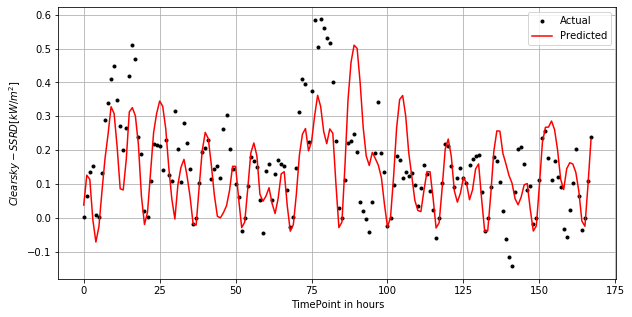

In [175]:
evaluate(dense, X_test, y_test)

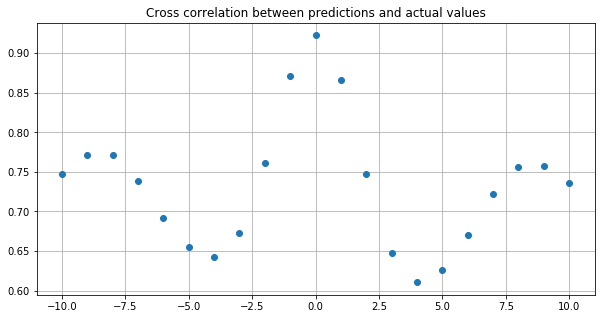

In [155]:
cross_corr(dense, X_test, y_test)

In [156]:
lstm = Sequential([
    LSTM(24, activation='relu', input_shape=(24,11), return_sequences=True),
    LSTM(24, activation='relu', return_sequences=True),
    LSTM(24, activation='relu'),
    Dense(1)
])
lstm.summary()
compile_and_fit(lstm, X_train, y_train)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 24)            3456      
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 24)            4704      
_________________________________________________________________
lstm_2 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 25        
Total params: 12,889
Trainable params: 12,889
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1104/1104 [==============================] - 413s 371ms/step - loss: 0.0296
Epoch 2/20
1104/1104 [==============================] - 403s 365ms/step - loss: 0.0188
Epoch 3/20
1104/1104 [==============================] - 382s 346ms/step - 

Test Score: 0.0928 RMSE


0.09280519030539838

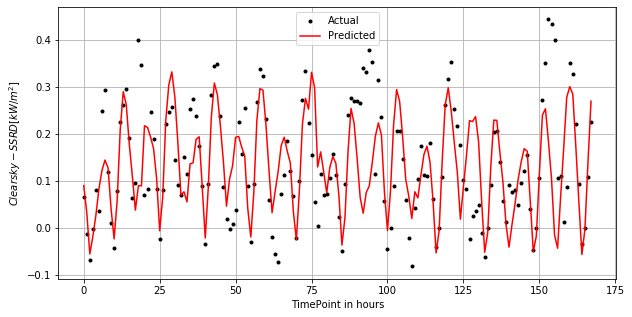

In [176]:
evaluate(lstm, X_test, y_test)

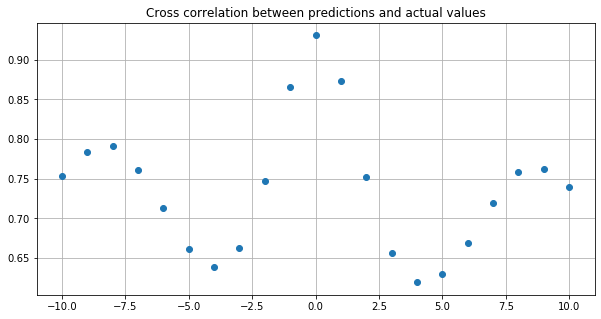

In [159]:
cross_corr(lstm, X_test, y_test)

In [161]:
dense.save('workdir/saved_models/theor-ssrd_dense.h5')

In [162]:
dense.save('workdir/saved_models/theor-ssrd_lstm.h5')